# 4. 어제 오른 내 주식, 과연 내일은?

## 4-9. 프로젝트 : 주식 예측에 도전해 보자

### 라이브러리 버전확인

In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

C:\Users\SUN\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.4.3
1.1.1
0.13.2


## STEP 1 : 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]

dataset_filepath = os.getenv('HOME') + '\\Desktop\\SUN\\aiffel\\EXPLORATION\\005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']


ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [3]:
# 결측치 처리
# [[YOUR CODE]]
ts= ts.interpolate(method='time')

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

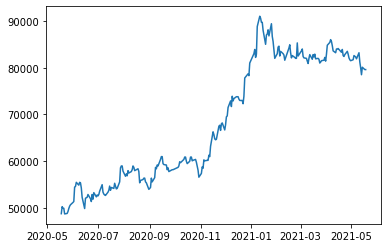

In [4]:
plt.plot(ts)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    


In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

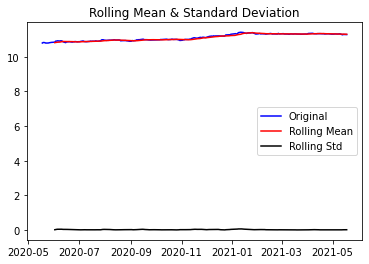

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


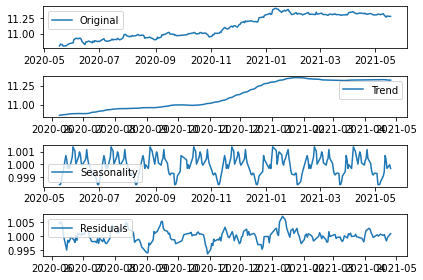

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

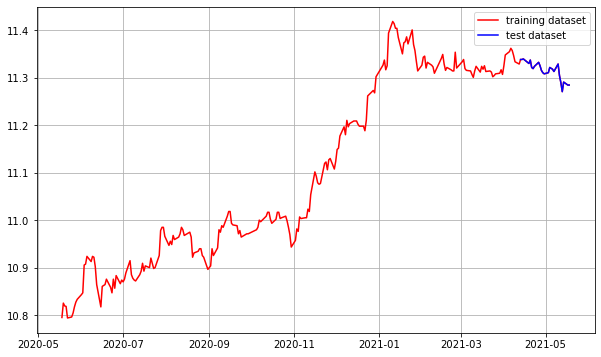

In [10]:

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


## STEP 5 : 적정 ARIMA 모수 찾기

C:\Users\SUN\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


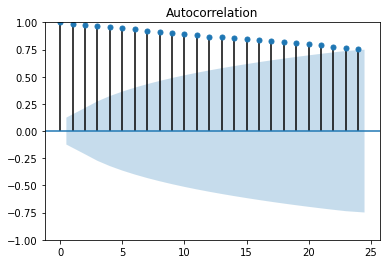

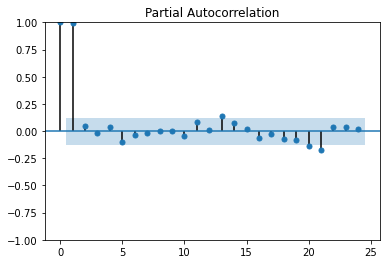

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


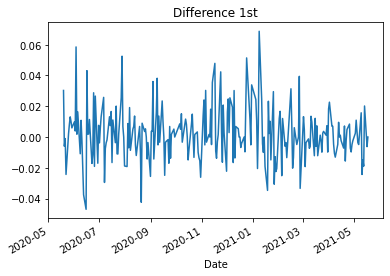

In [12]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


C:\Users\SUN\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SUN\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SUN\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 29 Sep 2022   AIC                          -1156.722
Time:                        01:25:59   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

C:\Users\SUN\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


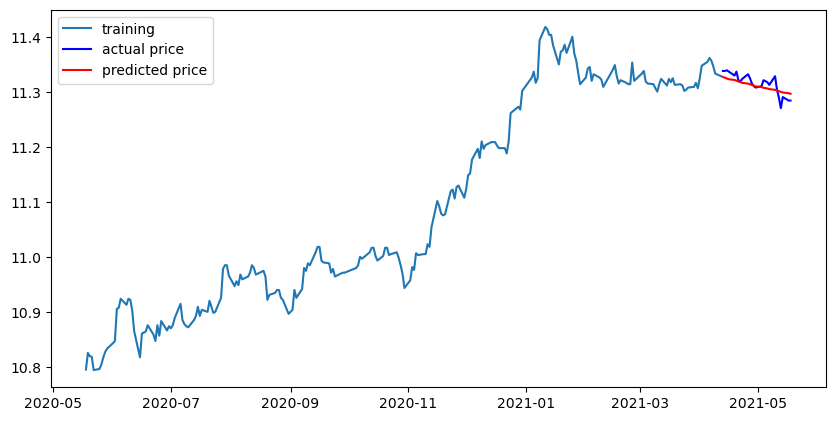

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1048973.6014240077
MAE:  843.7579531507118
RMSE:  1024.1941229200681
MAPE: 1.03%


## STEP 7 : 다른 주식 종목 예측해 보기

# ***1. 선정 주식 : TSLA

### STEP 1 : 시계열 데이터 준비

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성


dataset_filepath = os.getenv('HOME') + '\\Desktop\\SUN\\aiffel\\EXPLORATION\\TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) # data를 index_col로 지정
ts = df['Close']  # 종가만 사용할것


ts

Date
2021-09-27    263.786682
2021-09-28    259.186676
2021-09-29    260.436676
2021-09-30    258.493347
2021-10-01    258.406677
                 ...    
2022-09-21    300.799988
2022-09-22    288.589996
2022-09-23    275.329987
2022-09-26    276.010010
2022-09-27    282.940002
Name: Close, Length: 253, dtype: float64

### STEP 2 : 각종 전처리 수행

결측치 처리

로그 변환

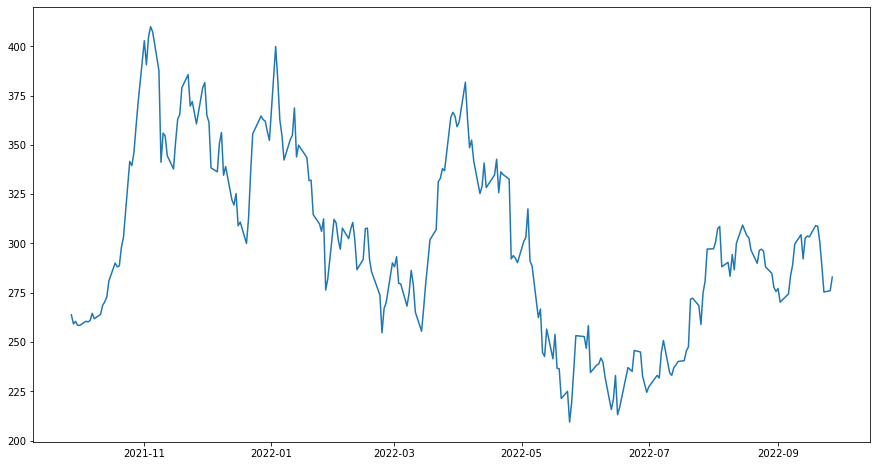

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8   # matlab 차트의 기본 크기를 15,8

plt.plot(ts)

In [18]:
ts[ts.isna()]  # 결측치 출력하기 

# 결측치가 없음

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


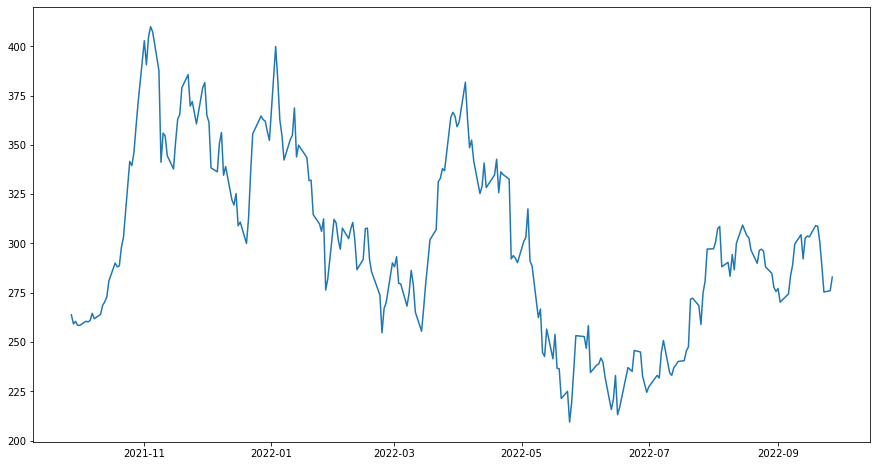

In [19]:
ts= ts.interpolate(method='time')  # 결측치가 있다면 보간하기. 보간의 기준은 time으로
print(ts[ts.isna()])               # 보간 후 결측치 유무 확인하기
plt.plot(ts)                       # 그래프 그려보기

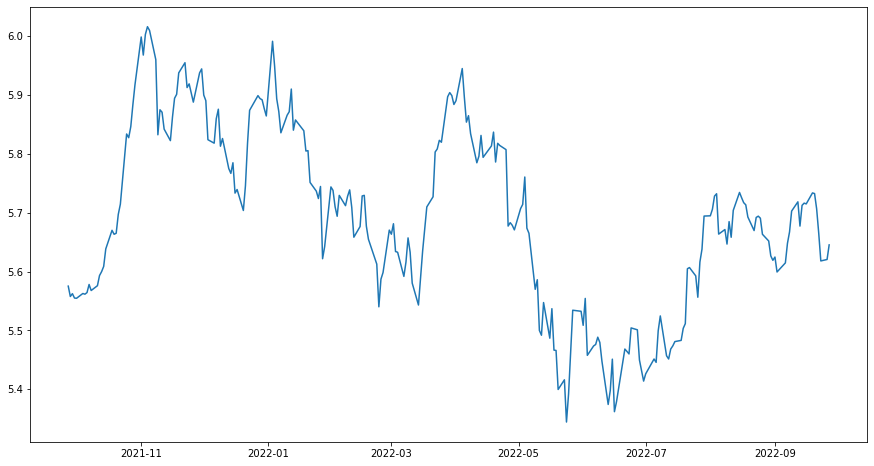

In [20]:
ts_log = np.log(ts)      # 로그 변환하기
plt.plot(ts_log)         # 로그 변환한뒤 그래프그려보기

### STEP 3 : 시계열 안정성 분석


정성적 그래프 분석

정량적 Augmented Dicky-Fuller Test

시계열 분해(Time Series Decomposition)

Residual 안정성 확인

In [21]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [22]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

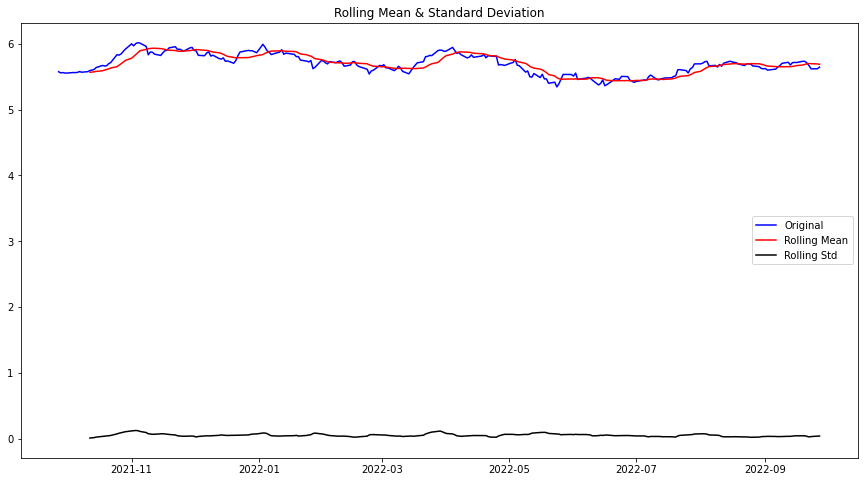

In [23]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 시간에 추이에 따라 시계열의 평균과 분산이 크게 증가하지않고 감소하는 추세를 보임
# 안정적인가? 

In [24]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 로그를 취해준 ts
# p-value가 0.824497 
# 안정적인 시계열이 아니라고 생각

Results of Dickey-Fuller Test:
Test Statistic                  -2.150660
p-value                          0.224638
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [25]:
augmented_dickey_fuller_test(ts)

# 여기도 마찬가지로 0.787830로 1에 가까운 수치

Results of Dickey-Fuller Test:
Test Statistic                  -2.190141
p-value                          0.209843
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


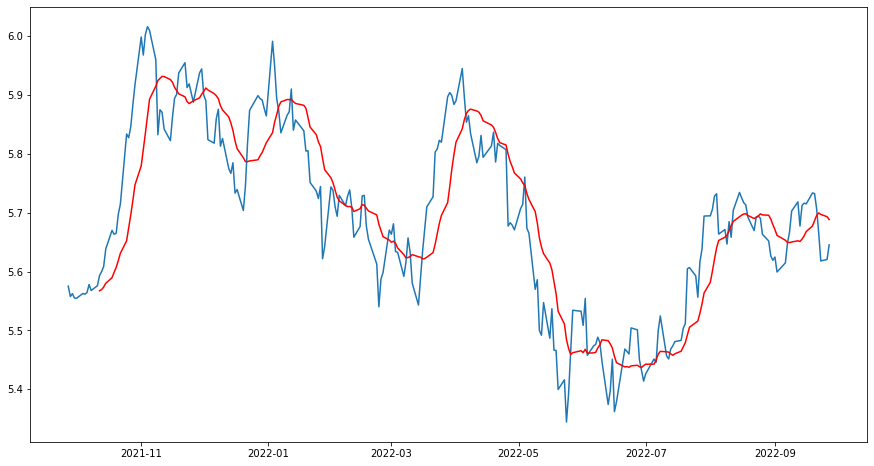

In [26]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [27]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

# 계산시 winodws size=12인 경우 
# 앞의 11개의 데이터는 Moving Average가 계산되지 않음
# ts_log_moving_avg에 결측치가 발생한다

# 얘들은 나중에 DF test시에 에러를 발생시킬것이기에 
# 데이터셋에서 제거해준다

Date
2021-09-27         NaN
2021-09-28         NaN
2021-09-29         NaN
2021-09-30         NaN
2021-10-01         NaN
2021-10-04         NaN
2021-10-05         NaN
2021-10-06         NaN
2021-10-07         NaN
2021-10-08         NaN
2021-10-11         NaN
2021-10-12    0.025840
2021-10-13    0.030419
2021-10-14    0.035048
2021-10-15    0.058462
Name: Close, dtype: float64

In [28]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-10-12    0.025840
2021-10-13    0.030419
2021-10-14    0.035048
2021-10-15    0.058462
2021-10-18    0.080484
2021-10-19    0.064688
2021-10-20    0.057923
2021-10-21    0.078671
2021-10-22    0.083534
2021-10-25    0.181443
2021-10-26    0.153507
2021-10-27    0.149869
2021-10-28    0.162739
2021-10-29    0.170034
2021-11-01    0.219035
Name: Close, dtype: float64

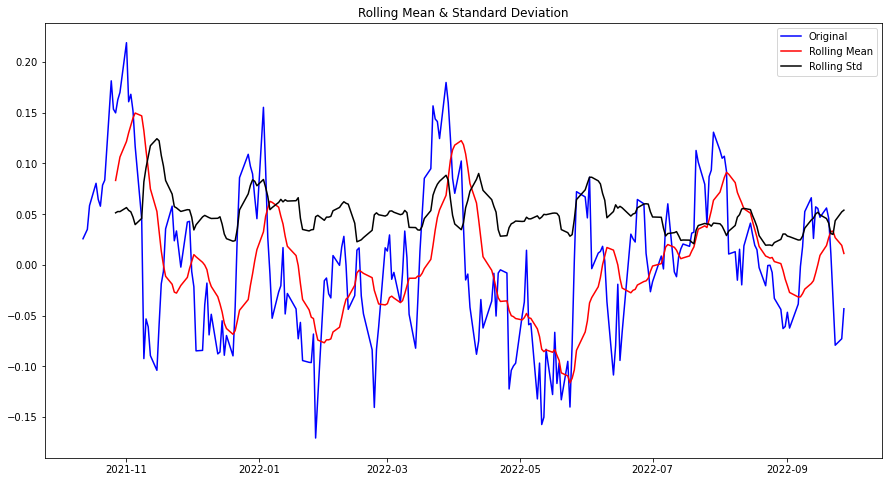

In [29]:
plot_rolling_statistics(ts_log_moving_avg)

In [30]:
augmented_dickey_fuller_test(ts_log_moving_avg)

# p-value 0.000034가된걸 확인
# 이 시계열은 안정하다고 할수 있을거같다

# moving average 를 계산하는 window=12로 지정해줘야한다

Results of Dickey-Fuller Test:
Test Statistic                  -3.799002
p-value                          0.002918
#Lags Used                      10.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


In [31]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

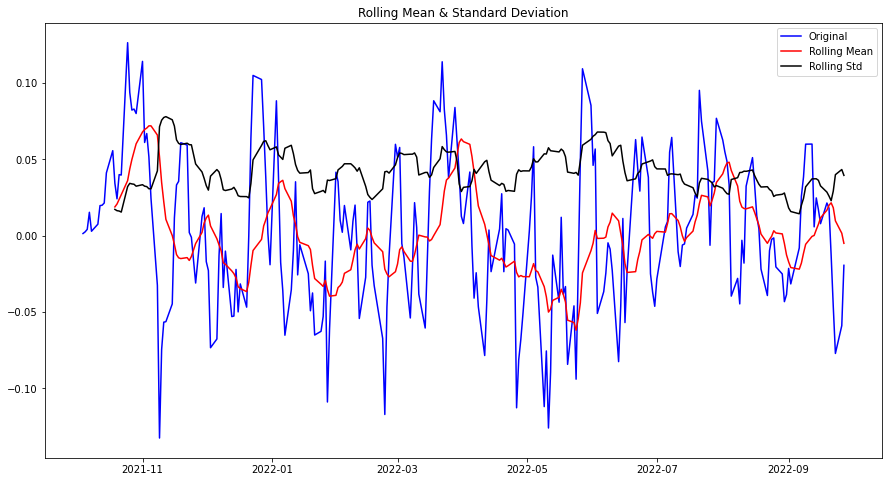

In [32]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [33]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)


# 그래프는 별차이가 없지만
# ADF test의 결과 p-value는 2.432093e-12로 안정적인 시계열이라고 판단
# 이 데이터셋은 월단위로 발생하는 시계열이므로 12개월 단위로 주기성이있다. window=12가 적당한이유.
# moving average를 고려할때는 rolling mean을 구하기 위한 window크기를 결정하는것도 중요하다
# 시간의추이에따라 평균이 증가하는 trend 제거.

Results of Dickey-Fuller Test:
Test Statistic                  -4.655200
p-value                          0.000102
#Lags Used                       9.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


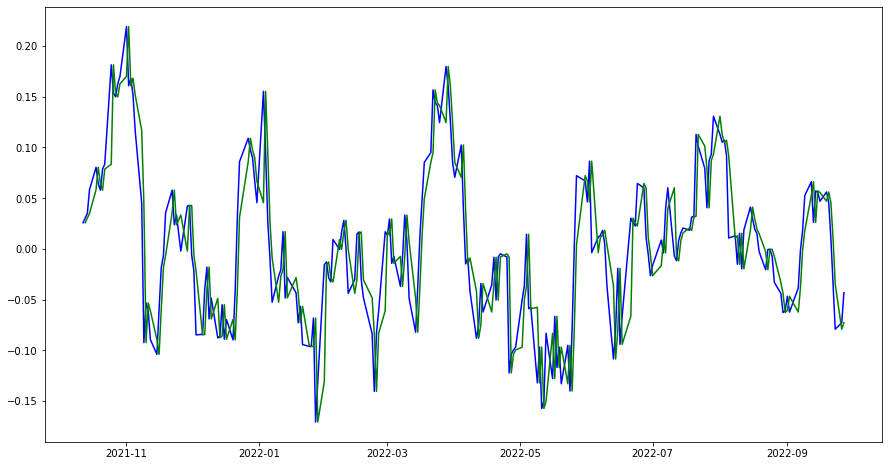

In [34]:
# 계절성

# 시프트한 시계열과 원본 시계열에 대한 그래프
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

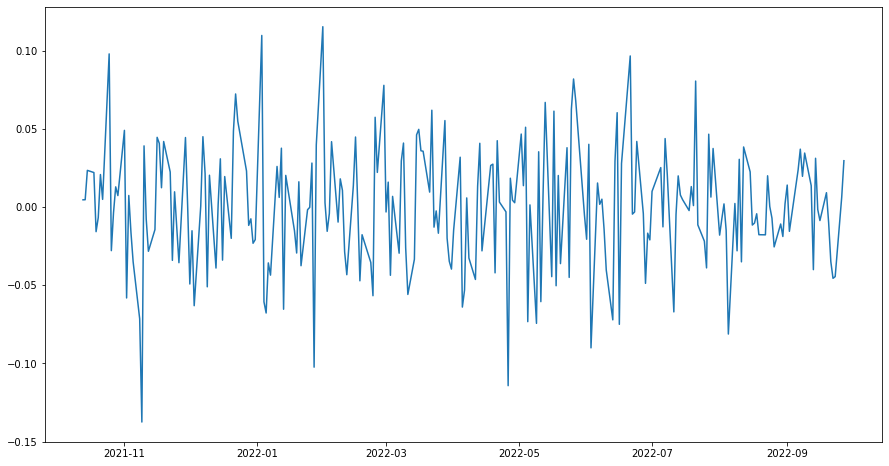

In [35]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로

ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

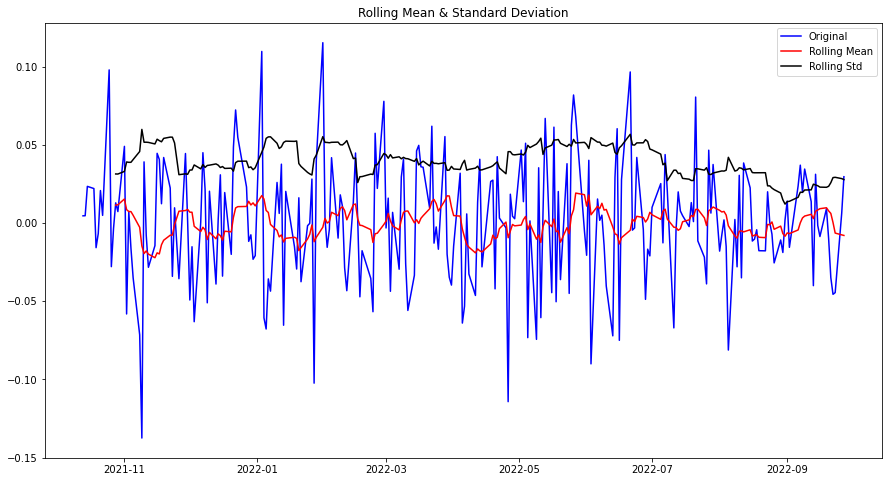

In [36]:
# 이동평균과 이동표준편차를 그래프에 나타내어 정성적으로 안정성여부 파악

plot_rolling_statistics(ts_log_moving_avg_diff)

In [37]:
# 차분의 효과확인

augmented_dickey_fuller_test(ts_log_moving_avg_diff)


# 이동평균을 빼주어 추세를 제거하고 난 시계열에다가 1차 차분을 적용하여
# 계절성 효과를 다소 상쇄한 결과, p-value가 약  2.432093e-12 -> 1.850932e-29로 줄어들었다

# 데이터에따라서 2차 차분, 3차 차분(2차 차분의 차분) 을 적용하면 더욱 p-value를 낮출수있을지도..?

Results of Dickey-Fuller Test:
Test Statistic                -6.744809e+00
p-value                        3.054092e-09
#Lags Used                     1.000000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


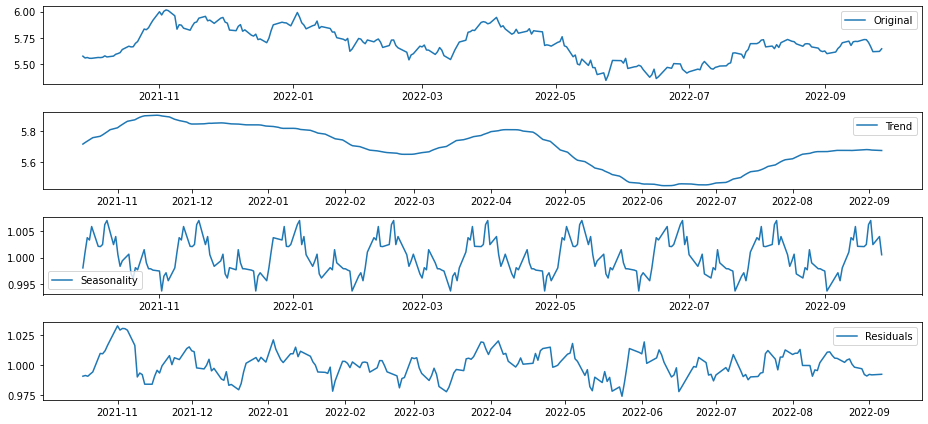

In [38]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend          # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal    # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid       # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (13,6)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

# origin시계열에서 trend 와 seasonality를 제거하고 난 나머지가 Residual
# 다른말로하면
# trend + seasonaliry + residual = original

# decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해준다

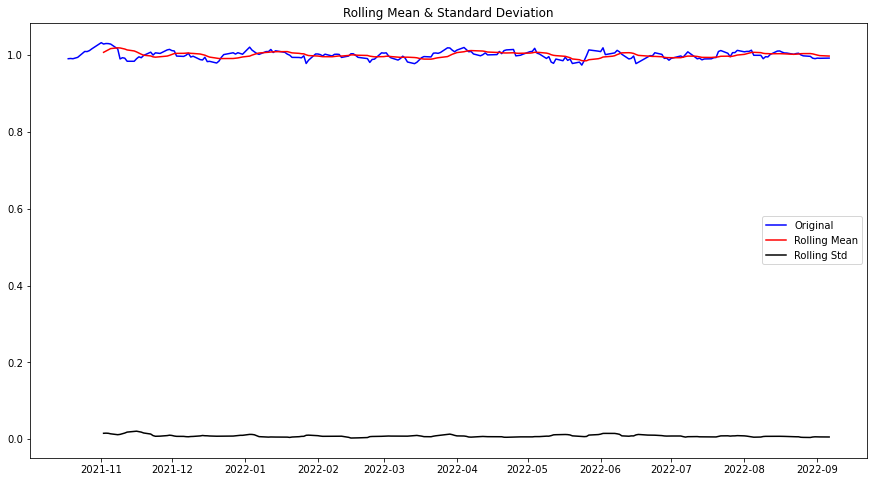

In [39]:
# residual 안정성 여부 따져보기

plt.rcParams["figure.figsize"] = (15,8)
plot_rolling_statistics(residual)

In [40]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# p-value  e-08 이니까 10 -8 제곱

Results of Dickey-Fuller Test:
Test Statistic                  -5.614047
p-value                          0.000001
#Lags Used                       9.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

학습, 테스트 데이터셋 분리

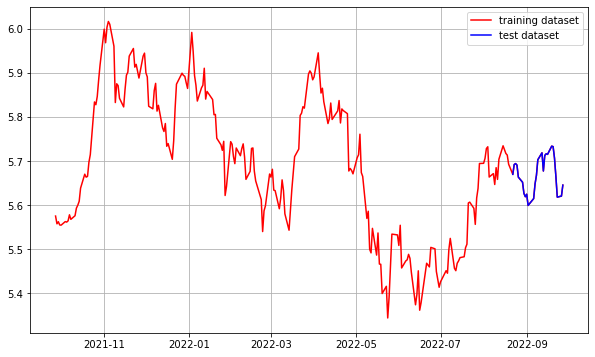

In [41]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

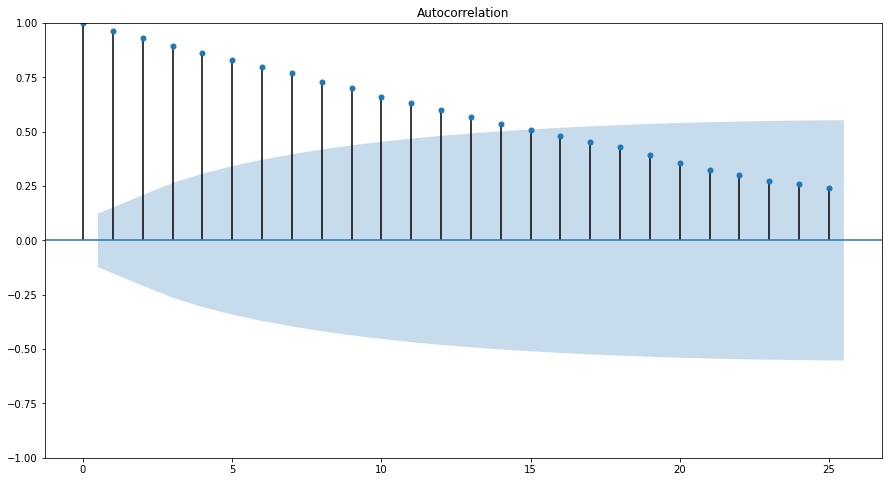

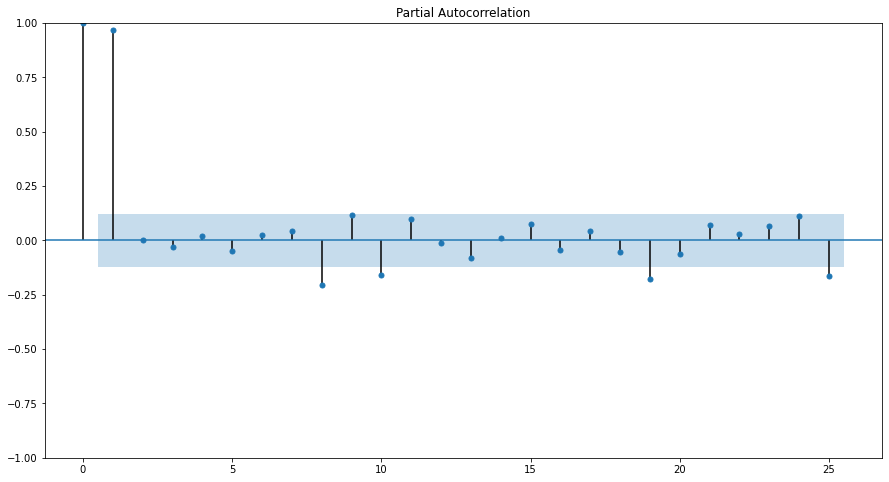

In [42]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.620808e+01
p-value                        4.012790e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


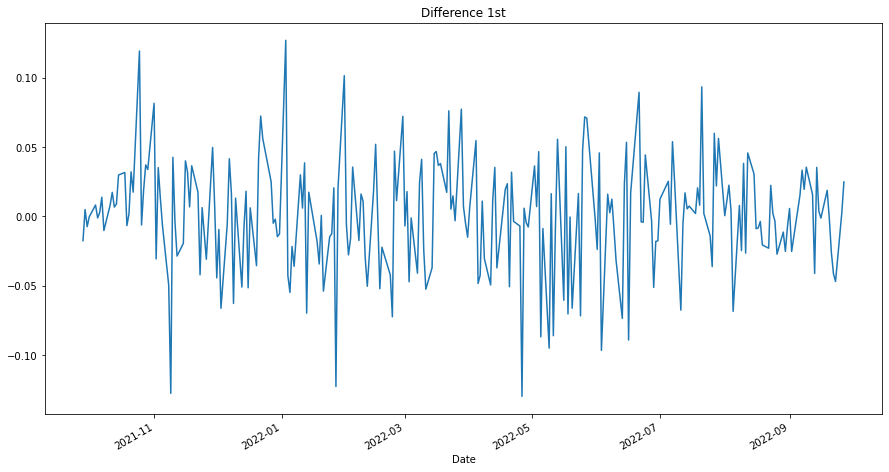

In [43]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.973811e+00
p-value                        8.529994e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


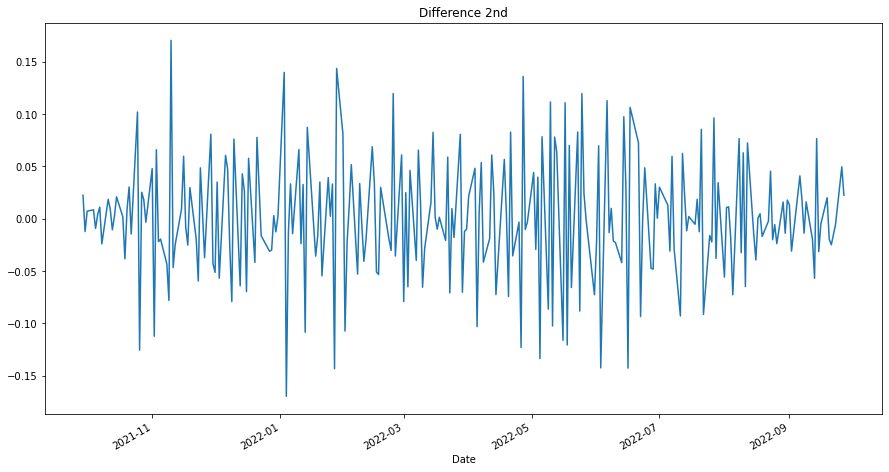

In [44]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [45]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  # p , d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 399.576
Date:                Thu, 29 Sep 2022   AIC                           -789.153
Time:                        01:26:06   BIC                           -772.028
Sample:                             0   HQIC                          -782.243
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6820      0.076     74.759      0.000       5.533       5.831
ar.L1          0.2135      3.474      0.061      0.951      -6.595       7.022
ar.L2          0.7226      3.350      0.216      0.8

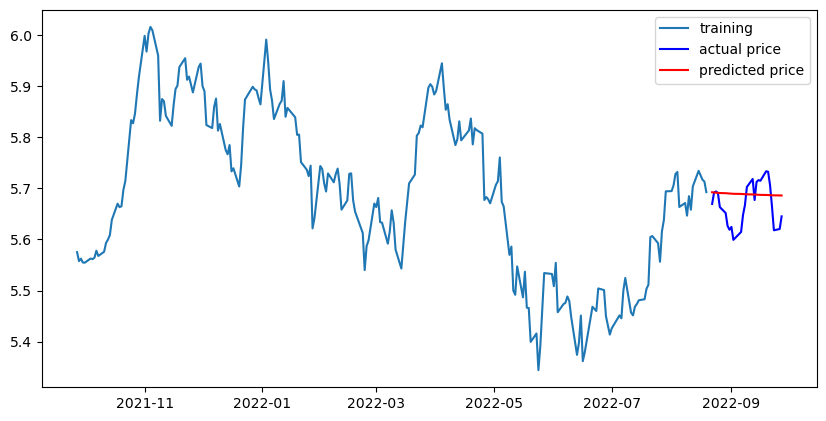

In [46]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE : ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE : ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE :', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE : {:.2f}%'.format(mape*100))

MSE :  163.37602169759154
MAE :  10.755563196896741
RMSE : 12.781862997919808
MAPE : 3.78%


### p , d, q 의 값에 따라
(2, 0, 1)  일 때, MAPE : 3.78%

(2, 1, 1) MAPE : 3.87%

(2, 2, 1) MAPE : 4.01%

(2, 2, 0) MAPE : 13.51%

(1, 2, 0) MAPE : 15.59%

(1, 1, 0) MAPE : 3.88%

(1, 1, 1) MAPE : 3.87%

(0, 1, 1) MAPE : 3.88%

으로 2, 0, 1일때 가장 낮은 MAPE를 확인

# ***2. 선정 주식 : DIS (The Walt Disney Company)

### STEP 1 : 시계열 데이터 준비

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성

dataset_filepath = os.getenv('HOME') + '\\Desktop\\SUN\\aiffel\\EXPLORATION\\DIS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']


ts

Date
2021-09-27    178.259995
2021-09-28    174.520004
2021-09-29    172.679993
2021-09-30    169.169998
2021-10-01    176.009995
                 ...    
2022-09-21    104.489998
2022-09-22    102.160004
2022-09-23     99.500000
2022-09-26     98.120003
2022-09-27     95.849998
Name: Close, Length: 253, dtype: float64

### STEP 2 : 각종 전처리 수행

In [49]:
ts= ts.interpolate(method='time')

ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

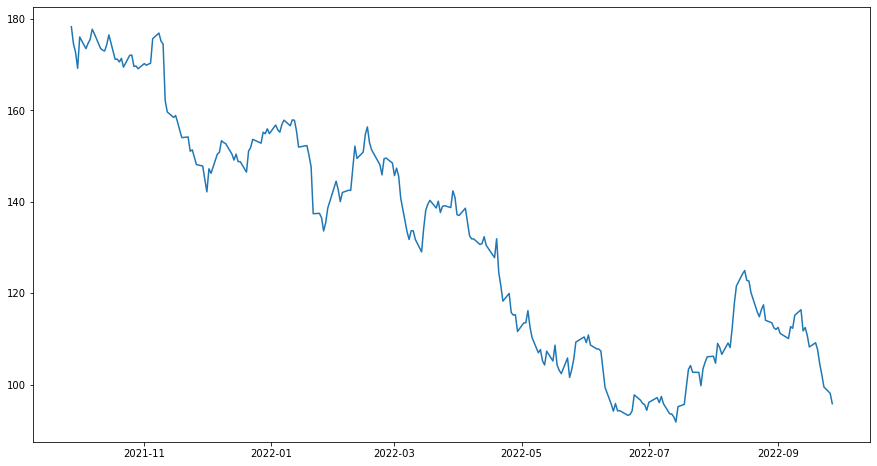

In [50]:
plt.plot(ts)

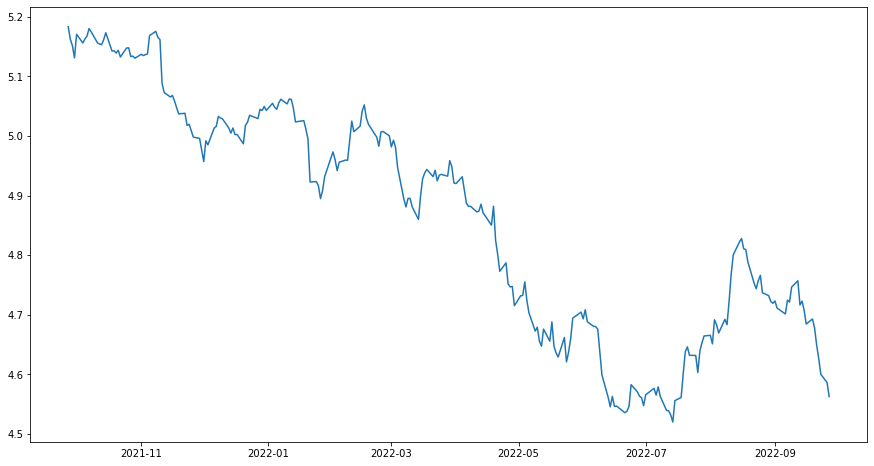

In [51]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

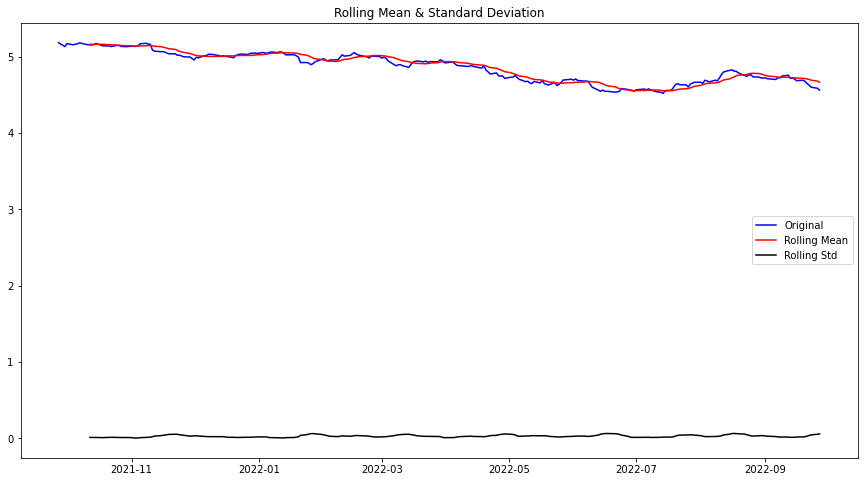

Results of Dickey-Fuller Test:
Test Statistic                  -0.913061
p-value                          0.783641
#Lags Used                       2.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


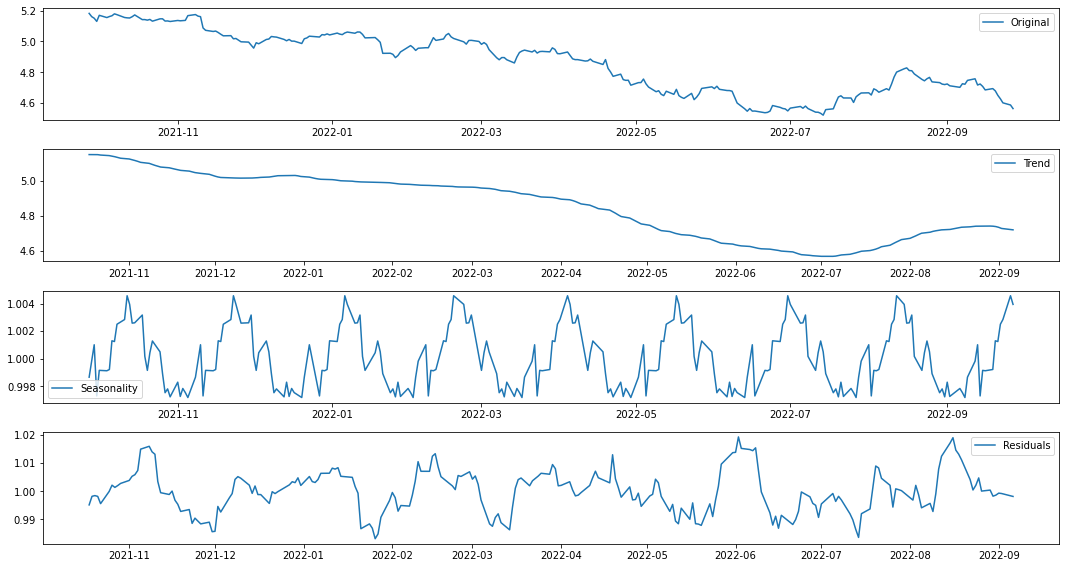

In [52]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [53]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.700355e+00
p-value                        7.701426e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

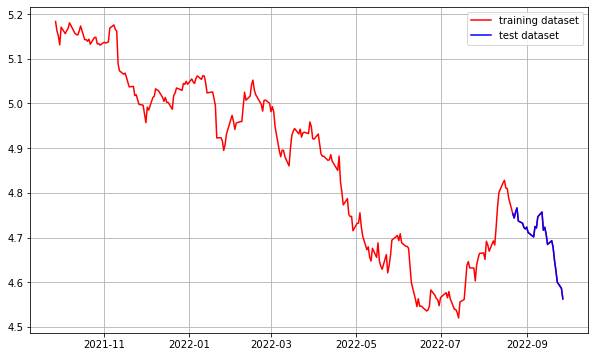

In [54]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

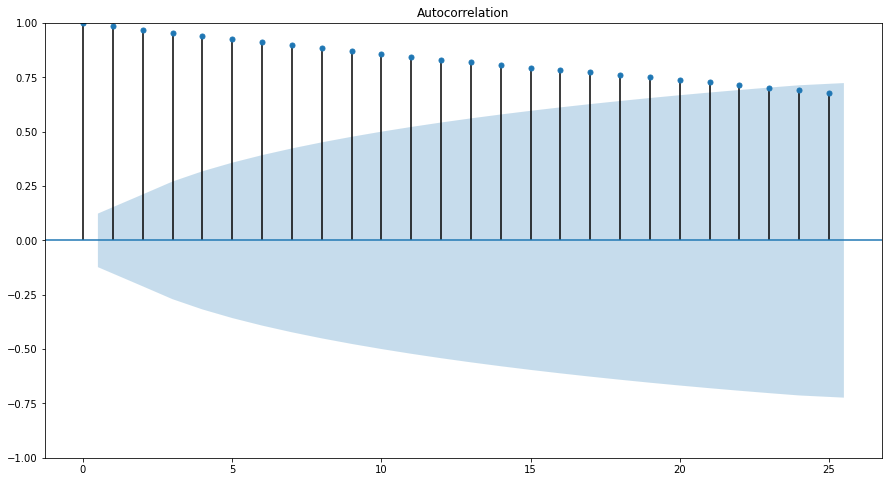

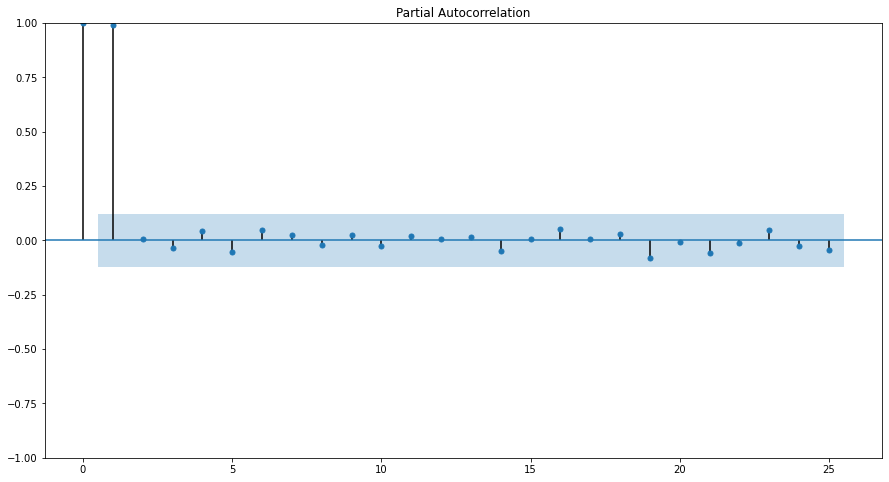

In [55]:
import warnings
warnings.filterwarnings('ignore') #경고 무시


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -9.427260e+00
p-value                        5.305475e-16
#Lags Used                     1.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


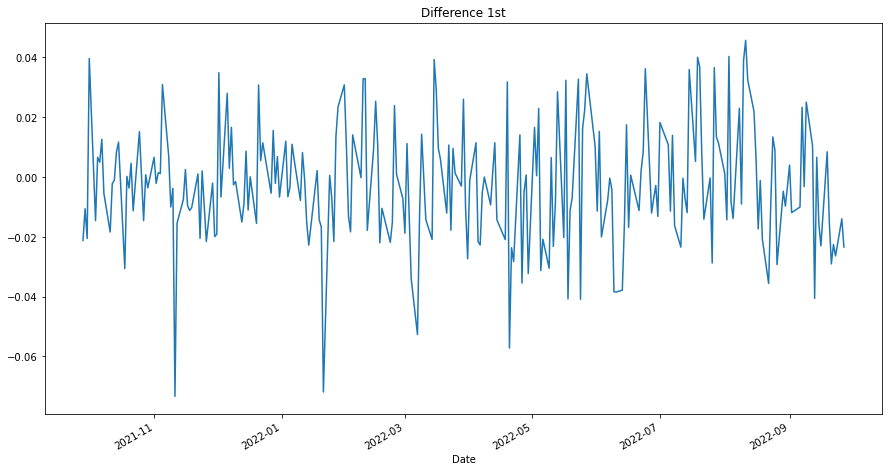

In [56]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.934150e+00
p-value                        9.635421e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


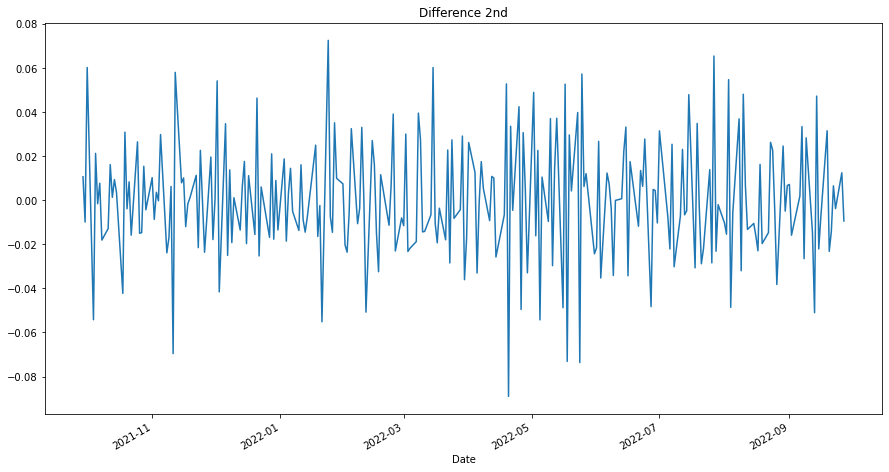

In [57]:
#필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -9.922513e+00
p-value                        2.965147e-17
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


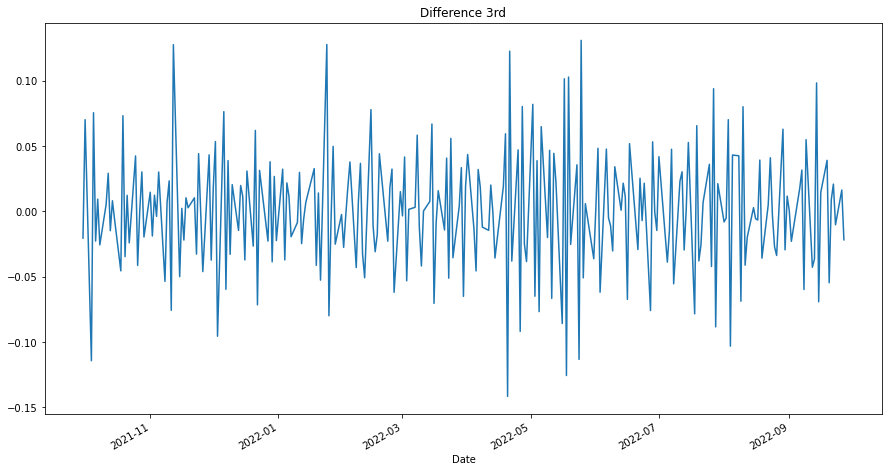

In [58]:
# 3차 차분
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)


# 1차 차분 5.305475e-16
# 2차 차분 9.635421e-15
# 3차 차분이 가장 낮은 p-value 2.965147e-17 값을 가지고있다

### STEP 6 : ARIMA 모델 훈련과 테스트

In [59]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 1))   # p, d ,q  
fitted_m = model.fit() 

print(fitted_m.summary())


# d가 2 : 10.38%
# d가 1 : 8.8%

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 563.021
Date:                Thu, 29 Sep 2022   AIC                          -1120.042
Time:                        01:26:09   BIC                          -1109.781
Sample:                             0   HQIC                         -1115.901
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6096      0.383      1.591      0.112      -0.142       1.361
ma.L1         -0.5085      0.408     -1.245      0.213      -1.309       0.292
sigma2         0.0004   3.22e-05     12.445      0.0

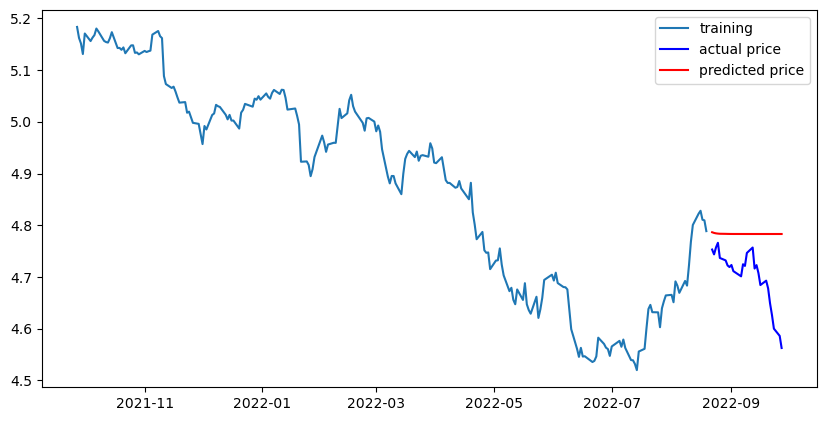

In [60]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE : ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE : ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE :', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE : {:.2f}%'.format(mape*100))

MSE :  117.28141931089573
MAE :  9.231881277148648
RMSE : 10.829654625651537
MAPE : 8.68%


### p , d, q 의 값에 따라
(2, 1, 1) MAPE: 8.80%

(2, 3, 1) MAPE: 9.61%

(1, 3, 1) MAPE: 9.61%

(0, 3, 1) MAPE: 17.22%

(0, 2, 1) MAPE: 13.65%

(0, 2, 0) MAPE: 17.24%

(0, 1, 0) MAPE: 9.25%

(0, 1, 1) MAPE: 9.07%

(1, 1, 1) MAPE: 8.68%

(1, 1, 2) MAPE: 8.87%

(1, 1, 0) MAPE : 9.03%

(1, 3, 0) MAPE : 43.52%

으로 1, 1, 1일때 가장 낮은 MAPE를 확인

# ***3. 선정 주식 : GOOG (Alphabet Inc.)

### STEP 1 : 시계열 데이터 준비

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성

dataset_filepath = os.getenv('HOME') + '\\Desktop\\SUN\\aiffel\\EXPLORATION\\GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts

Date
2021-09-27    141.501007
2021-09-28    136.184006
2021-09-29    134.520996
2021-09-30    133.265503
2021-10-01    136.462494
                 ...    
2022-09-21    100.010002
2022-09-22    100.570000
2022-09-23     99.169998
2022-09-26     98.809998
2022-09-27     98.089996
Name: Close, Length: 253, dtype: float64

### STEP 2 : 각종 전처리 수행

In [63]:
ts= ts.interpolate(method='time')

ts[ts.isna()]

Series([], Name: Close, dtype: float64)

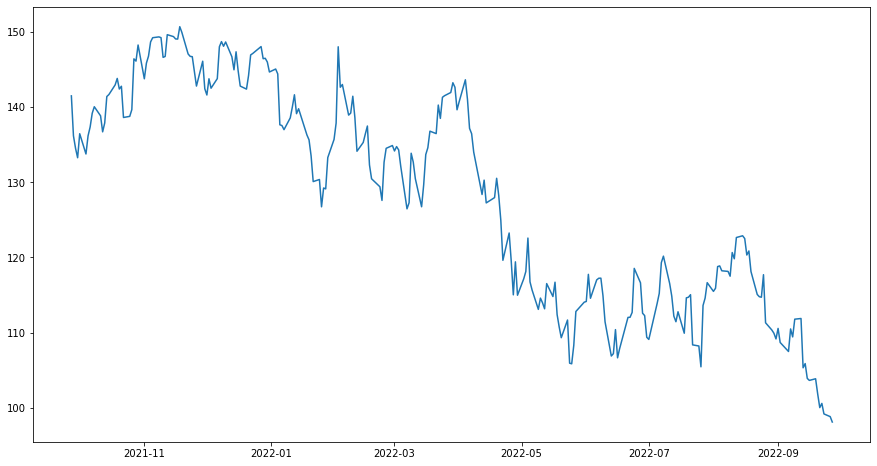

In [64]:
plt.plot(ts)

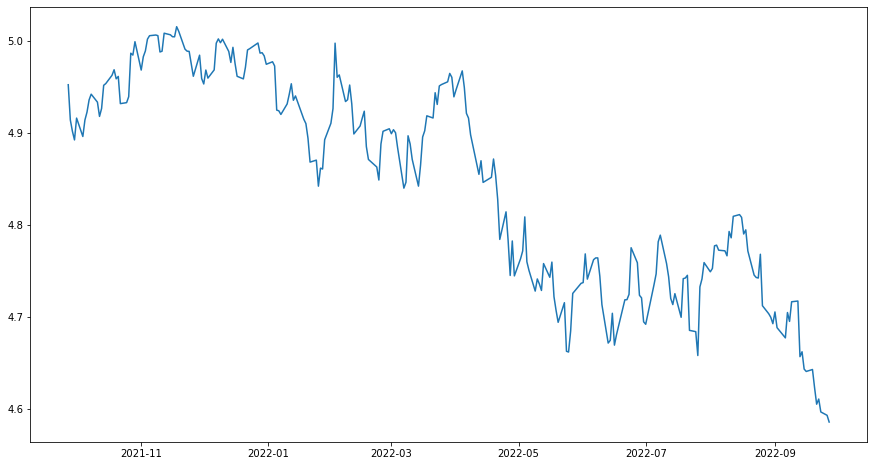

In [65]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

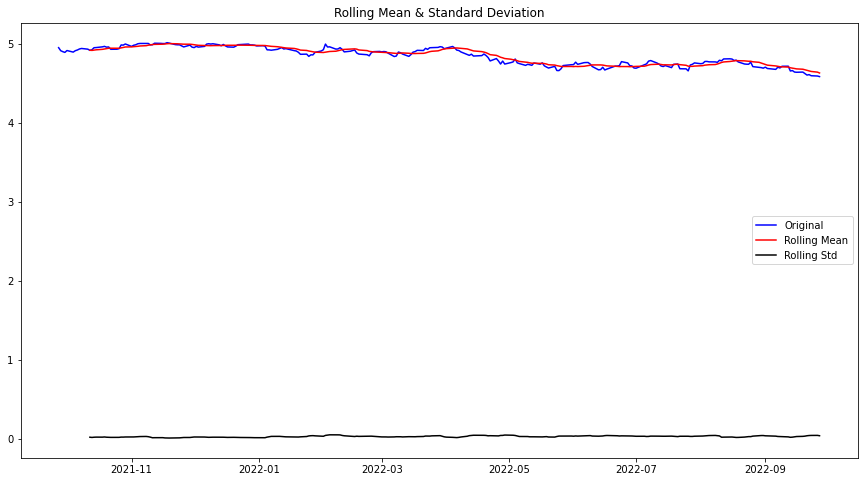

Results of Dickey-Fuller Test:
Test Statistic                  -0.781496
p-value                          0.824497
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


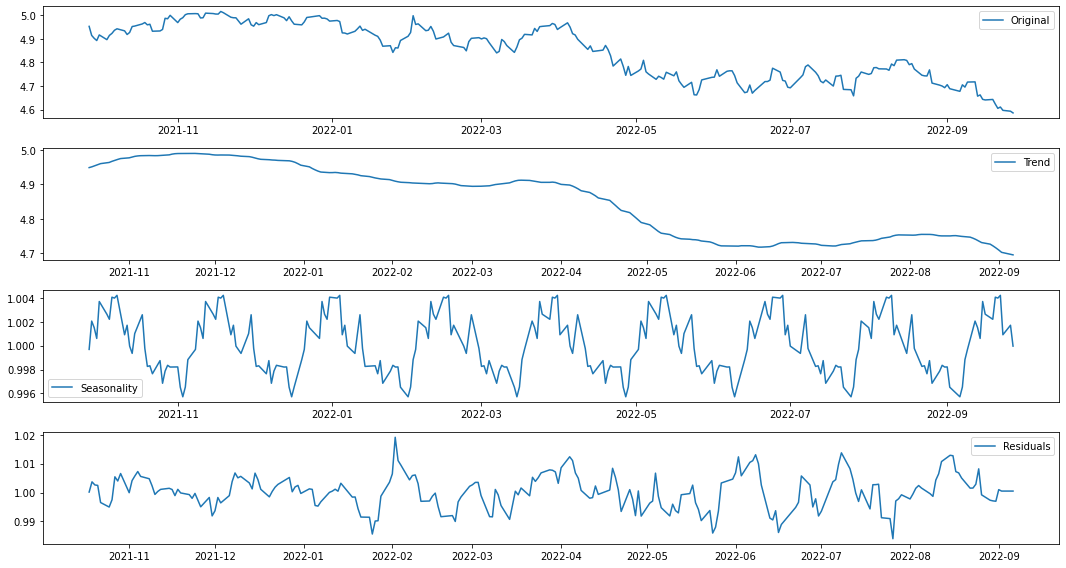

In [66]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [67]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.281299e+00
p-value                        3.790737e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

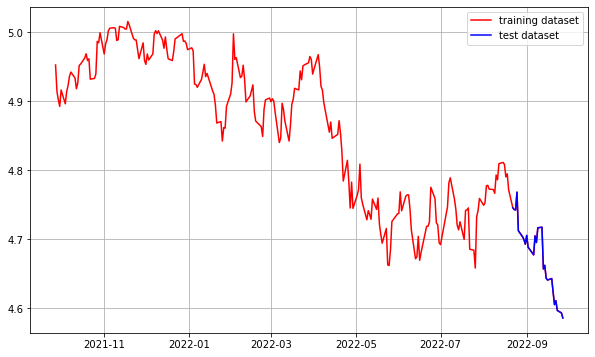

In [68]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

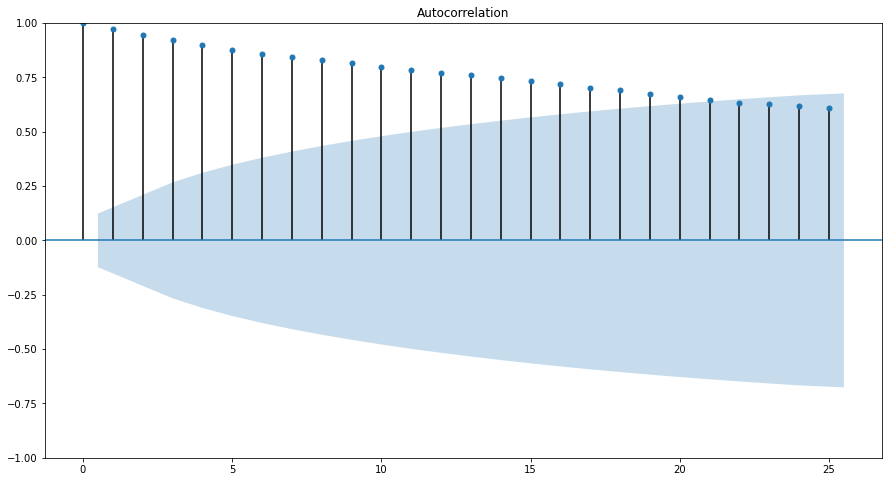

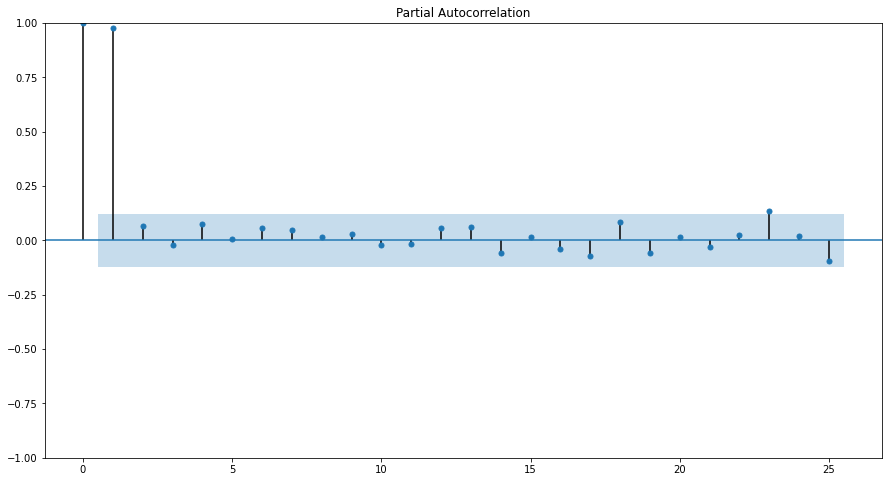

In [69]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.709408e+01
p-value                        7.555631e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


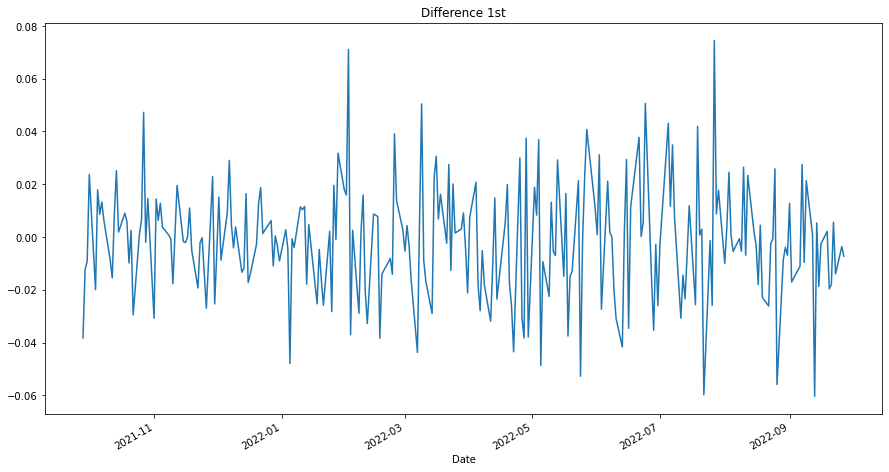

In [70]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.736787e+00
p-value                        1.088312e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


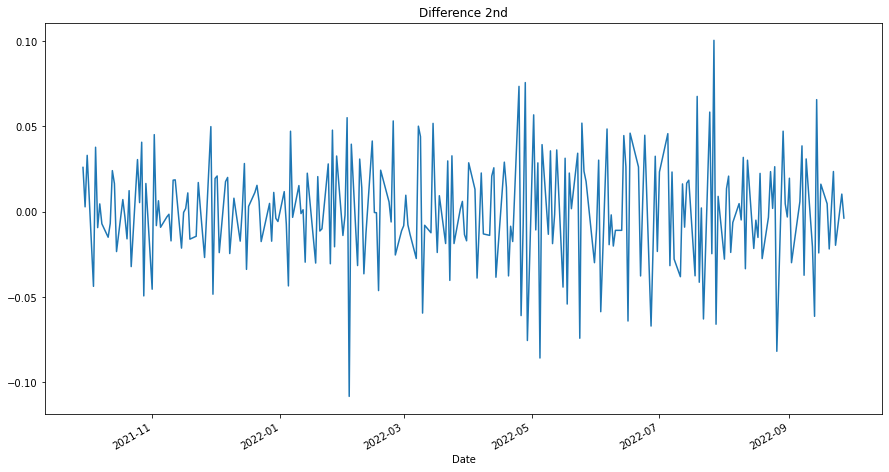

In [71]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -8.531739e+00
p-value                        1.033267e-13
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


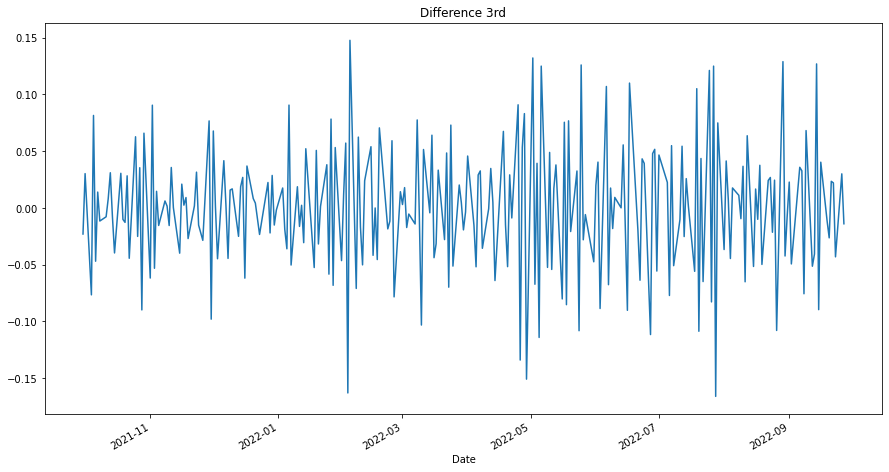

In [72]:
# 3차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

1차 차분 p-value                        7.555631e-30

2차 차분 p-value                        1.088312e-11

3차 차분 p-value                        1.033267e-13

로 1차 차분의 p-value 값이 가장 낮았다

### STEP 6 : ARIMA 모델 훈련과 테스트


In [73]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 3, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 3, 1)   Log Likelihood                 498.698
Date:                Thu, 29 Sep 2022   AIC                           -989.396
Time:                        01:26:12   BIC                           -975.750
Sample:                             0   HQIC                          -983.888
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6836      0.067    -10.253      0.000      -0.814      -0.553
ar.L2         -0.2488      0.062     -4.024      0.000      -0.370      -0.128
ma.L1         -0.9965      0.183     -5.451      0.0

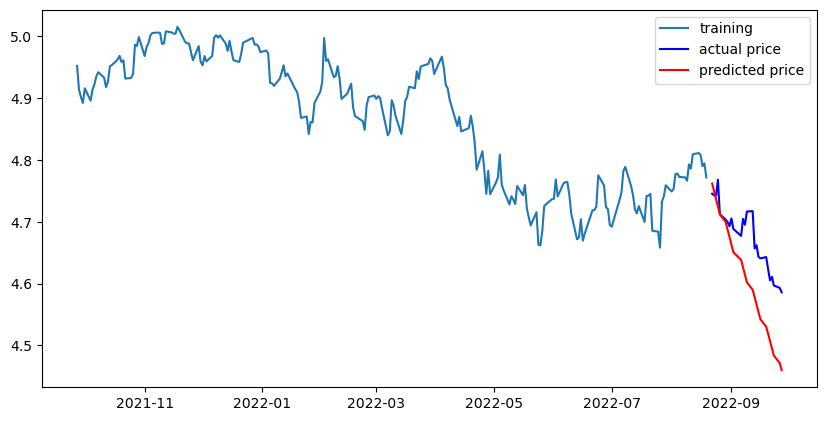

In [74]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE : ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE : ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE :', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE : {:.2f}%'.format(mape*100))

MSE :  65.28281842210333
MAE :  6.866636513552692
RMSE : 8.079778364664673
MAPE : 6.54%


### p , d, q 의 값에 따라
(2, 3, 1) MAPE : 6.54%

(2, 2, 1) MAPE : 9.06%

(2, 3, 0) MAPE : 40.13%

(1, 3, 0) MAPE : 49.05%

(0, 3, 1) MAPE : 18.00%

(0, 1, 1) MAPE : 10.36%

(1, 1, 1) MAPE : 10.37%

(1, 2, 1) MAPE : 9.19%

(1, 2, 2) MAPE : 9.28%

으로 2, 3, 1일때 가장 낮은 MAPE를 확인

# 회고

- 이번 프로젝트에서 **어려웠던 점,**

이번 노드가 전체적으로 잘 이해가 가지 않아서 프로젝트를 시작하는 시점에도 학습에 대한 이해를 완벽하게 숙지하지 못하고 시작했다.

그런 상태에서 프로젝트를 보니 코드를 복사하고 붙여넣기를 하면서 학습했다.

그래프를 이해하는데 어려움을 겪었다. 검색도 해보고 노드도 다시 살펴보았지만 여전히 이해하기는 어렵다.

- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.

처음에 접한 p-value 값이 노드에서 예를들어 3.1234e-10 가 나오면 굉장히 작은숫자다. 라고했는데

그 부분이 이해가 가지 않았다. 알아보니 e-10이 10의 -10승이 였다.

ACF와 PACF, MAPE 의 정확한 개념이 완벽하게 이해되지 않았다.

ARIMA(train_data, order=(2, 3, 1))에서 order 순서대로 p,d,q

- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

3개 이상 종목의 MAPE가 15% 미만이 되도록 여러가지 값을 시도해 본것

- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.낌

첫번째 테슬라 주식과 다르게 디즈니랑 구글은 조금 설명이 부족한것

- **자기 다짐**
내용이 어려워서 프로젝트를 진행하며 이해했다.

반복적으로 보다보니 조금씩이해가 되는걸 보아하니 꾸준히 반복적으로 학습하는게 정말 도움이 되는구나 싶었다

시계열을 예측해 실제 주식데이터를 가지고 앞으로의 상황을 예측해본다는게 신기했다.

구글주식은 예측이 하락이던데 정말로 나중에 하락하려나? 하는 궁금증이 생기기도 했다.

ACF, PACF, MAPE에 대해서 다시 한번 더 짚고 넘어가야 할 필요가 있는것같다.


